In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [2]:
mnist = fetch_openml('mnist_784', version = 1)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X = mnist['data'].to_numpy().astype('float32')
y = mnist['target'].to_numpy().astype('int')

In [4]:
X /= 255.0

In [5]:
encoder = OneHotEncoder(sparse_output = False)
y = encoder.fit_transform(y.reshape(-1, 1))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [7]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

Training with Adam optimizer...
Epoch 0: Train Loss: 0.3725, Test Loss: 0.2059, Test Accuracy: 0.9397
Epoch 5: Train Loss: 0.0561, Test Loss: 0.0961, Test Accuracy: 0.9706
Epoch 10: Train Loss: 0.0186, Test Loss: 0.0877, Test Accuracy: 0.9746
Epoch 15: Train Loss: 0.0059, Test Loss: 0.0957, Test Accuracy: 0.9747
Epoch 20: Train Loss: 0.0036, Test Loss: 0.1141, Test Accuracy: 0.9731
Epoch 25: Train Loss: 0.0039, Test Loss: 0.1138, Test Accuracy: 0.9751

Training with SGD optimizer...
Epoch 0: Train Loss: 0.5438, Test Loss: 0.3004, Test Accuracy: 0.9158
Epoch 5: Train Loss: 0.1303, Test Loss: 0.1444, Test Accuracy: 0.9579
Epoch 10: Train Loss: 0.0766, Test Loss: 0.1103, Test Accuracy: 0.9678
Epoch 15: Train Loss: 0.0518, Test Loss: 0.0938, Test Accuracy: 0.9721
Epoch 20: Train Loss: 0.0370, Test Loss: 0.0873, Test Accuracy: 0.9738
Epoch 25: Train Loss: 0.0272, Test Loss: 0.0823, Test Accuracy: 0.9757


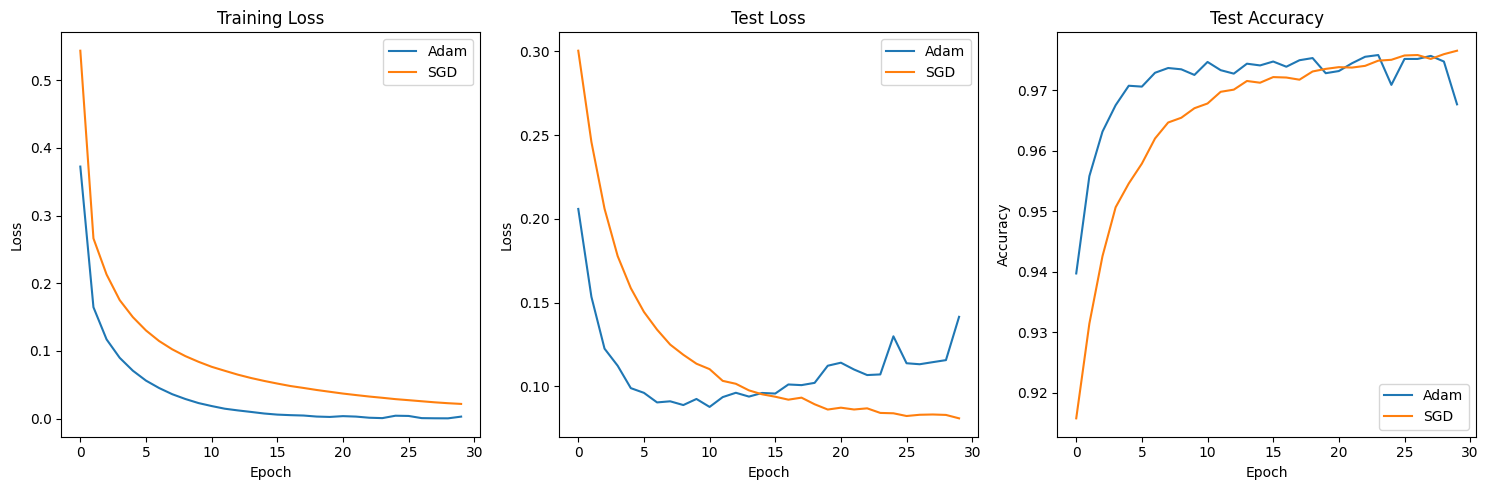

In [8]:
class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases
        self.w1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.w2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

    def forward(self, X):
        # Forward pass
        self.z1 = np.dot(X, self.w1) + self.b1
        self.a1 = np.tanh(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        self.a2 = self.softmax(self.z2)
        return self.a2

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def backward(self, X, y):
        # Backward pass
        m = y.shape[0]
        dz2 = self.a2 - y
        self.dw2 = np.dot(self.a1.T, dz2) / m
        self.db2 = np.sum(dz2, axis=0, keepdims=True) / m
        dz1 = np.dot(dz2, self.w2.T) * (1 - np.tanh(self.z1) ** 2)
        self.dw1 = np.dot(X.T, dz1) / m
        self.db1 = np.sum(dz1, axis=0, keepdims=True) / m

    def get_parameters(self):
        return [self.w1, self.b1, self.w2, self.b2]

    def get_gradients(self):
        return [self.dw1, self.db1, self.dw2, self.db2]

# Simplified Adam optimizer
class Adam:
    def __init__(self, parameters, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.parameters = parameters  # List of model parameters
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        # Initialize first and second moment estimates for each parameter
        self.m = [np.zeros_like(p) for p in self.parameters]
        self.v = [np.zeros_like(p) for p in self.parameters]
        self.t = 0  # Time step

    def step(self, grads):
        self.t += 1
        for i, (param, grad) in enumerate(zip(self.parameters, grads)):
            # Update biased first moment estimate
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            # Update biased second moment estimate
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)

            # Compute bias-corrected estimates
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            # Update parameter
            param -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

# Simplified SGD optimizer
class SGD:
    def __init__(self, parameters, lr=0.01):
        self.parameters = parameters
        self.lr = lr

    def step(self, grads):
        for param, grad in zip(self.parameters, grads):
            param -= self.lr * grad

# Training function
def train(model, optimizer, X_train, y_train, X_test, y_test, epochs, batch_size=64):
    history = {'train_loss': [], 'test_loss': [], 'test_accuracy': []}
    num_batches = X_train.shape[0] // batch_size

    for epoch in range(epochs):
        # Shuffle training data
        permutation = np.random.permutation(X_train.shape[0])
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        epoch_loss = 0

        for i in range(num_batches):
            # Get batch data
            start = i * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]

            # Forward pass
            output = model.forward(X_batch)
            loss = np.mean(-np.sum(y_batch * np.log(output + 1e-8), axis=1))  # Cross-entropy loss
            epoch_loss += loss

            # Backward pass
            model.backward(X_batch, y_batch)

            # Get gradients
            grads = model.get_gradients()

            # Update weights
            optimizer.step(grads)

        # Average loss per epoch
        avg_epoch_loss = epoch_loss / num_batches
        history['train_loss'].append(avg_epoch_loss)

        # Evaluate on test set
        test_output = model.forward(X_test)
        test_loss = np.mean(-np.sum(y_test * np.log(test_output + 1e-8), axis=1))
        test_preds = np.argmax(test_output, axis=1)
        test_labels = np.argmax(y_test, axis=1)
        test_accuracy = np.mean(test_preds == test_labels)

        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_accuracy)

        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Train Loss: {avg_epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    return history


input_size = 784
hidden_size = 128
output_size = 10
epochs = 30
batch_size = 64

print("Training with Adam optimizer...")
model_adam = SimpleNN(input_size, hidden_size, output_size)
parameters_adam = model_adam.get_parameters()
adam_optimizer = Adam(parameters_adam, lr=0.001)
adam_history = train(model_adam, adam_optimizer, X_train, y_train, X_test, y_test, epochs, batch_size)


print("\nTraining with SGD optimizer...")
model_sgd = SimpleNN(input_size, hidden_size, output_size)
parameters_sgd = model_sgd.get_parameters()
sgd_optimizer = SGD(parameters_sgd, lr=0.1)
sgd_history = train(model_sgd, sgd_optimizer, X_train, y_train, X_test, y_test, epochs, batch_size)


import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(adam_history['train_loss'], label='Adam')
plt.plot(sgd_history['train_loss'], label='SGD')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot test loss
plt.subplot(1, 3, 2)
plt.plot(adam_history['test_loss'], label='Adam')
plt.plot(sgd_history['test_loss'], label='SGD')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(adam_history['test_accuracy'], label='Adam')
plt.plot(sgd_history['test_accuracy'], label='SGD')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()